In [1]:
import numpy as np
import pandas as pd

import os, sys
import random
import sklearn

try:
    os.chdir('CrowdInference')
    sys.path.append(os.getcwd())
except:
    pass

import crowd_inference.methods.dawid_skene as ds
import crowd_inference.methods.majority_vote as mv
import crowd_inference.methods.raykar as r
import crowd_inference.methods.raykar_boosting as rb
import crowd_inference.methods.raykar_plus_ds as rds
import crowd_inference.methods.classifier as cls
import benchmark as bm

from crowd_inference.truth_inference import NoFeaturesInference, TruthInference, WithFeaturesInference
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression
import matplotlib.pyplot as plt
from collections import defaultdict
import tests.data_provider as data
from tqdm.auto import tqdm

import seaborn as sns
sns.set()
sns.set(font_scale=1.2)

from importlib import reload

def reload_all():
    reload(ds)
    reload(r)
    reload(rb)
    reload(rds)
    reload(cls)
    reload(bm)

reload(data)

<module 'tests.data_provider' from '/Users/andrey/Documents/5Course/CrowdInference/tests/data_provider.py'>

In [2]:
sentiment_data = data.SentimentDataProvider('./resources/datasets/sentiment_polarity/mturk_answers.csv',
                                       './resources/datasets/sentiment_polarity/polarity_gold_lsa_topics.csv')

Iter 00, logit: -3.010473
Iter 03, logit: -2.782851
Iter 06, logit: -2.780372
Iter 09, logit: -2.779957
Iter 12, logit: -2.779823
[0.50522958 0.49477042]
---------------
Label accuracy is 0.9147829565913183
--------------------------------------------------
Data has 600 features
Iter 00, logit: -2.930729
Iter 03, logit: -2.623034
Iter 06, logit: -2.612418
Iter 09, logit: -2.611111
Iter 12, logit: -2.610835
(4999, 600)
Classifier train accuracy is 0.7093418683736747
(5428, 600)
Classifier test accuracy is 0.6298820928518791
Label accuracy is 0.9157831566313263
--------------------------------------------------
Data has 600 features
Iter 00, logit: -2.952768
Average Raykar weight is 0.6149776159072102
Iter 03, logit: -2.622331
Average Raykar weight is 0.5620165163815279
Iter 06, logit: -2.588905
Average Raykar weight is 0.5852705856412934
Iter 09, logit: -2.582872
Average Raykar weight is 0.589434131362204
Iter 12, logit: -2.581731
Average Raykar weight is 0.5901659633390322
Average Rayk

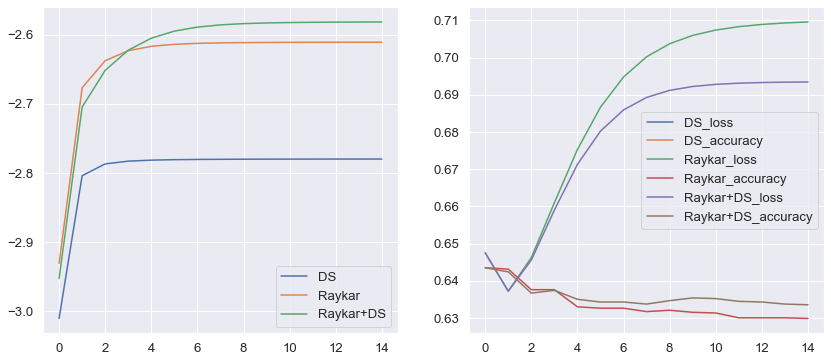

In [3]:
reload_all()
sentiment_methods, sentiment_points, advantages_matrix = bm.compare_methods(sentiment_data, max_iter=15, lr=0.5)
# Classifier test accuracy is 0.6298820928518791

Number of data points: 4999


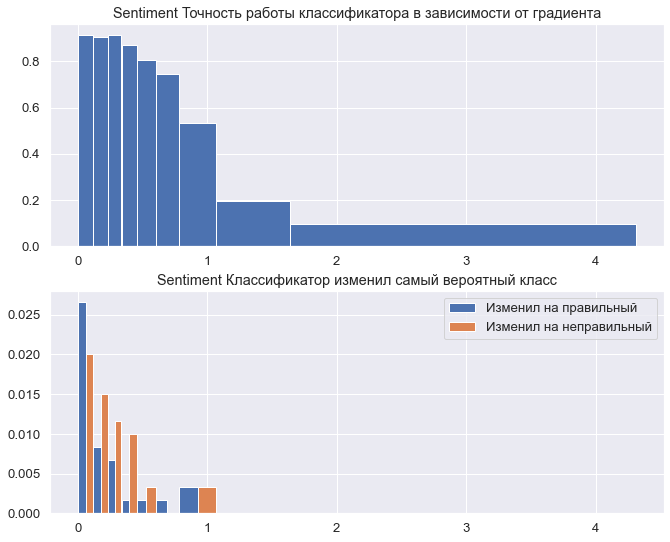

In [4]:
buckets, confidences, wrong, correct = bm.build_grad_hist(sentiment_data, sentiment_methods, sentiment_points, 'Sentiment', 600)
condidence_sentiment = bm.get_confidence(buckets[0], confidences[0])

Iter 00, logit: -3.010473
Iter 03, logit: -2.782851
Iter 06, logit: -2.780372
Iter 09, logit: -2.779957
Iter 12, logit: -2.779823
[0.50522958 0.49477042]
---------------
Label accuracy is 0.9147829565913183
--------------------------------------------------
Data has 600 features
Iter 00, logit: -2.930729
Iter 03, logit: -2.623034
Iter 06, logit: -2.612418
Iter 09, logit: -2.611111
Iter 12, logit: -2.610835
(4999, 600)
Classifier train accuracy is 0.7093418683736747
(5428, 600)
Classifier test accuracy is 0.6298820928518791
Label accuracy is 0.9157831566313263
--------------------------------------------------
Data has 600 features
Iter 00, logit: -2.940931
Average Raykar weight is 0.7569550610289562
Iter 03, logit: -2.589660
Average Raykar weight is 0.690263952287945
Iter 06, logit: -2.558037
Average Raykar weight is 0.7006401313763589
Iter 09, logit: -2.552104
Average Raykar weight is 0.7024331583234569
Iter 12, logit: -2.551031
Average Raykar weight is 0.7026024300337455
Average Rayk

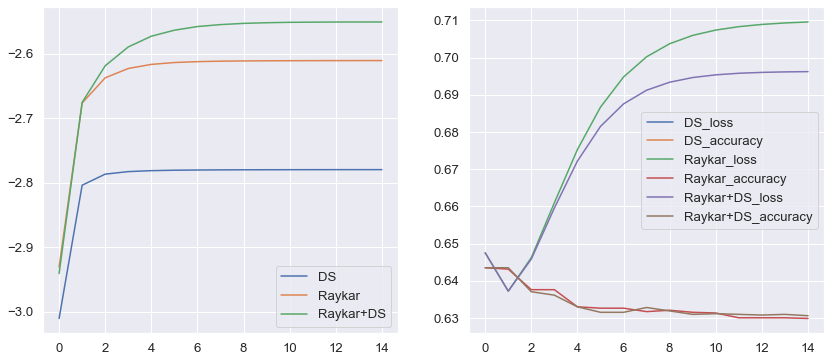

In [5]:
reload_all()
sentiment_methods, sentiment_points, advantages_matrix = bm.compare_methods(sentiment_data, max_iter=15, lr=0.5, 
                                                                            confidence_estimator=condidence_sentiment)

In [6]:
sentiment_points[sentiment_points.task.isin(advantages_matrix[0][1])]

,task,mu_ds,conf_mx_ds,mu_r,conf_mx_r,classifier_r,grad_r,mu_rds,conf_mx_rds,classifier_rds,grad_rds,likelihood_rds,index
6,15,"[0.146, 0.854]","[-5.897, -4.113]","[0.732, 0.268]","[-5.595, -4.253]","[0.913, 0.087]","[0.45342, 0.57078, 0.56103, 0.49285, 0.42159, ...","[0.3, 0.7]","[-5.82, -4.106]","[0.881, 0.119]",0.88858,"[0.532, 0.468]",6
97,204,"[0.336, 0.664]","[-3.965, -3.265]","[0.546, 0.454]","[-3.986, -3.343]","[0.696, 0.304]","[0.35157, 0.35871, 0.33, 0.30421, 0.28629, 0.2...","[0.505, 0.495]","[-3.986, -3.327]","[0.678, 0.322]",0.27565,"[0.915, 0.085]",97
169,339,"[0.31, 0.69]","[-6.77, -5.949]","[0.854, 0.146]","[-6.771, -6.114]","[0.918, 0.082]","[0.24214, 0.41284, 0.37865, 0.33213, 0.29025, ...","[0.601, 0.399]","[-6.782, -6.035]","[0.849, 0.151]",0.65927,"[0.745, 0.255]",169
339,682,"[0.088, 0.912]","[-7.51, -5.151]","[0.513, 0.487]","[-6.507, -5.261]","[0.785, 0.215]","[0.42847, 0.50558, 0.60723, 0.65115, 0.65514, ...","[0.254, 0.746]","[-6.824, -5.195]","[0.752, 0.248]",0.99199,"[0.532, 0.468]",339
767,1577,"[0.433, 0.567]","[-6.356, -6.064]","[0.635, 0.365]","[-6.245, -5.911]","[0.708, 0.292]","[0.14967, 0.28136, 0.31084, 0.28119, 0.24272, ...","[0.566, 0.434]","[-6.369, -5.971]","[0.677, 0.323]",0.20772,"[0.905, 0.095]",767
1170,2412,"[0.196, 0.804]","[-7.402, -5.967]","[0.678, 0.322]","[-7.123, -5.994]","[0.867, 0.133]","[0.53812, 0.06143, 0.47014, 0.57644, 0.58301, ...","[0.212, 0.788]","[-7.457, -5.959]","[0.725, 0.275]",1.21794,"[0.198, 0.802]",1170
1352,2805,"[0.167, 0.833]","[-4.596, -2.97]","[0.943, 0.057]","[-4.733, -3.101]","[0.988, 0.012]","[1.03662, 0.95566, 0.80244, 0.63559, 0.46623, ...","[0.171, 0.829]","[-4.732, -2.987]","[0.917, 0.083]",1.81588,"[0.095, 0.905]",1352
1640,3412,"[0.245, 0.755]","[-6.431, -5.283]","[0.669, 0.331]","[-6.357, -5.398]","[0.841, 0.159]","[0.51055, 0.50726, 0.48607, 0.45115, 0.41409, ...","[0.521, 0.479]","[-6.39, -5.33]","[0.846, 0.154]",0.67228,"[0.745, 0.255]",1640
1666,3475,"[0.031, 0.969]","[-5.811, -2.342]","[0.591, 0.409]","[-5.829, -2.418]","[0.978, 0.022]","[1.20234, 1.48712, 1.5515, 1.50032, 1.38663, 1...","[0.035, 0.965]","[-5.844, -2.34]","[0.958, 0.042]",1.96692,"[0.095, 0.905]",1666
1733,3614,"[0.223, 0.777]","[-6.222, -4.951]","[0.893, 0.107]","[-5.896, -5.348]","[0.936, 0.064]","[0.45983, 0.5375, 0.48433, 0.38102, 0.27461, 0...","[0.776, 0.224]","[-5.966, -5.299]","[0.91, 0.09]",0.22972,"[0.905, 0.095]",1733


In [7]:
sentiment_points[sentiment_points.task.isin(advantages_matrix[1][0])]

,task,mu_ds,conf_mx_ds,mu_r,conf_mx_r,classifier_r,grad_r,mu_rds,conf_mx_rds,classifier_rds,grad_rds,likelihood_rds,index
340,684,"[0.528, 0.472]","[-5.667, -5.756]","[0.428, 0.572]","[-5.843, -5.703]","[0.462, 0.538]","[0.7503, 0.23003, 0.02797, 0.0373, 0.06506, 0....","[0.455, 0.545]","[-5.831, -5.716]","[0.482, 0.518]",0.08048,"[0.912, 0.088]",340
476,981,"[0.502, 0.498]","[-4.901, -4.887]","[0.242, 0.758]","[-5.149, -4.75]","[0.322, 0.678]","[0.43591, 0.33312, 0.23371, 0.20714, 0.19909, ...","[0.283, 0.717]","[-5.124, -4.793]","[0.34, 0.66]",0.14197,"[0.905, 0.095]",476
493,1013,"[0.756, 0.244]","[-6.8, -7.912]","[0.324, 0.676]","[-7.121, -7.614]","[0.226, 0.774]","[0.11926, 0.11858, 0.11917, 0.12485, 0.12269, ...","[0.444, 0.556]","[-7.044, -7.794]","[0.25, 0.75]",0.18276,"[0.905, 0.095]",493
597,1231,"[0.512, 0.488]","[-5.563, -5.588]","[0.179, 0.821]","[-5.949, -4.8]","[0.407, 0.593]","[0.27991, 0.34334, 0.37965, 0.39096, 0.39878, ...","[0.196, 0.804]","[-5.887, -4.925]","[0.379, 0.621]",0.33664,"[0.915, 0.085]",597
626,1295,"[0.883, 0.117]","[-3.688, -5.685]","[0.199, 0.801]","[-3.732, -5.475]","[0.042, 0.958]","[0.0887, 0.59001, 0.73112, 0.6975, 0.61201, 0....","[0.838, 0.162]","[-3.701, -5.635]","[0.124, 0.876]",1.47594,"[0.198, 0.802]",626
863,1772,"[0.64, 0.36]","[-6.12, -6.675]","[0.352, 0.648]","[-6.1, -6.47]","[0.272, 0.728]","[0.20854, 0.13104, 0.04919, 0.00409, 0.03321, ...","[0.39, 0.61]","[-6.192, -6.548]","[0.291, 0.709]",0.11075,"[0.912, 0.088]",863
911,1847,"[0.613, 0.387]","[-6.367, -6.806]","[0.104, 0.896]","[-6.492, -6.165]","[0.138, 0.862]","[0.48727, 0.23203, 0.10406, 0.07494, 0.06693, ...","[0.156, 0.844]","[-6.431, -6.222]","[0.155, 0.845]",0.00162,"[0.912, 0.088]",911
933,1888,"[0.592, 0.408]","[-6.368, -6.72]","[0.015, 0.985]","[-6.42, -6.606]","[0.012, 0.988]","[0.6949, 0.41245, 0.12918, 0.055, 0.02999, 0.0...","[0.082, 0.918]","[-6.401, -6.647]","[0.02, 0.98]",0.17299,"[0.905, 0.095]",933
939,1901,"[0.966, 0.034]","[-5.871, -9.183]","[0.079, 0.921]","[-6.119, -6.419]","[0.06, 0.94]","[0.3328, 0.10039, 0.10815, 0.16339, 0.15044, 0...","[0.139, 0.861]","[-6.142, -6.55]","[0.055, 0.945]",0.21729,"[0.905, 0.095]",939
1106,2281,"[0.975, 0.025]","[-4.321, -7.98]","[0.42, 0.58]","[-4.503, -7.542]","[0.033, 0.967]","[0.91436, 1.38959, 1.45999, 1.42292, 1.34297, ...","[0.962, 0.038]","[-4.455, -7.841]","[0.074, 0.926]",1.92880,"[0.095, 0.905]",1106


/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


46 41


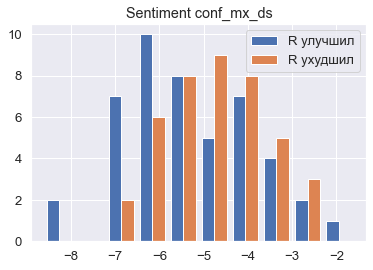

In [8]:
reload_all()
bm.plot_flips(sentiment_points[sentiment_points.task.isin(advantages_matrix[1][0])], 
              sentiment_points[sentiment_points.task.isin(advantages_matrix[0][1])], 'conf_mx_ds', 'Sentiment', 'R улучшил', 'R ухудшил')

In [9]:
reload_all()
bm.plot_flips(sentiment_points[sentiment_points.task.isin(advantages_matrix[1][0])], 
              sentiment_points[sentiment_points.task.isin(advantages_matrix[0][1])], 'conf_mx_ds', 'Sentiment')

TypeError: plot_flips() missing 2 required positional arguments: 'l1' and 'l2'

In [ ]:
bm.plots_for_point(sentiment_points, sentiment_data, sentiment_methods, 4624)

In [ ]:
def scatter_cls(pts):
    print(len(pts))
    r = list(map(lambda x: x[0], pts['classifier_r']))
    rds = list(map(lambda x: x[0], pts['classifier_rds']))
    plt.scatter(r, rds)
    
scatter_cls(sentiment_points[sentiment_points.task.isin(advantages_matrix[0][1])])

In [ ]:
res = []
for _, row in sentiment_points.iterrows():
    res.append(row.conf_mx_r + np.log(row.classifier_r) + np.log(row.classifier_rds))
res = np.array(res)
res = np.exp(res)
res = sklearn.preprocessing.normalize(res, axis=1, norm='l1')

estimates = {}
for i, row in sentiment_points.iterrows():
    estimates[row['task']] = sentiment_methods[2].values[np.argmax(res[i])]
    
    all_points = 0
accepted = 0

for point in sentiment_data.gold():
    if point.task in estimates:
        estimate = estimates[point.task]
        all_points += 1
        if point.value == estimate:
            accepted += 1

accuracy = accepted / all_points

accuracy

In [ ]:
reload_all()
bm.boosting_classifiers_distr(sentiment_points[sentiment_points.task.isin(advantages_matrix[1][0])],
                              sentiment_points[sentiment_points.task.isin(advantages_matrix[0][1])], 'Sentiment') 

In [ ]:
reload_all()
bm.plot_all_gradients(sentiment_points[sentiment_points.task.isin(advantages_matrix[1][0])],
                              sentiment_points[sentiment_points.task.isin(advantages_matrix[0][1])], 'Sentiment') 

In [ ]:
plt.plot(sentiment_methods[1].losses)